<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[15:08:58] /work/mxnet/src/storage/storage.cc:199: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


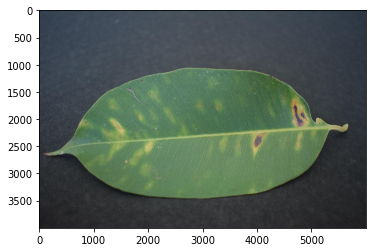

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

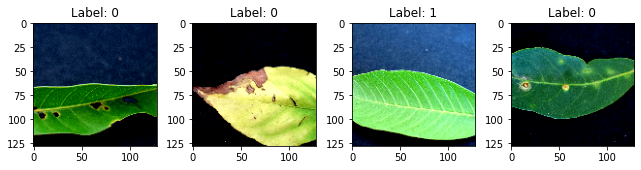

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
ctx = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, ctx=ctx)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), ctx=ctx))
model.hybridize()

[15:09:04] /work/mxnet/src/storage/storage.cc:199: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[15:09:06] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:97: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.as_in_ctx(ctx))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.as_in_ctx(ctx))
            loss = loss_fn(outputs, label.as_in_ctx(ctx))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.2505263070019328 samples/sec                   batch loss = 0.6532250046730042 | accuracy = 0.4


Epoch[1] Batch[10] Speed: 1.2510833024922687 samples/sec                   batch loss = 1.2846009731292725 | accuracy = 0.425


Epoch[1] Batch[15] Speed: 1.2627623573859734 samples/sec                   batch loss = 0.7231406569480896 | accuracy = 0.5166666666666667


Epoch[1] Batch[20] Speed: 1.250123300643667 samples/sec                   batch loss = 1.1261756420135498 | accuracy = 0.5125


Epoch[1] Batch[25] Speed: 1.2404284106721162 samples/sec                   batch loss = 0.8266777992248535 | accuracy = 0.54


Epoch[1] Batch[30] Speed: 1.2631610965545743 samples/sec                   batch loss = 0.9389297366142273 | accuracy = 0.575


Epoch[1] Batch[35] Speed: 1.240390901827322 samples/sec                   batch loss = 0.7746760845184326 | accuracy = 0.5785714285714286


Epoch[1] Batch[40] Speed: 1.2588209748072476 samples/sec                   batch loss = 0.39044272899627686 | accuracy = 0.58125


Epoch[1] Batch[45] Speed: 1.2681312006448435 samples/sec                   batch loss = 0.5387894511222839 | accuracy = 0.6


Epoch[1] Batch[50] Speed: 1.261091801144687 samples/sec                   batch loss = 0.43853798508644104 | accuracy = 0.615


Epoch[1] Batch[55] Speed: 1.265081493288187 samples/sec                   batch loss = 0.49993494153022766 | accuracy = 0.6272727272727273


Epoch[1] Batch[60] Speed: 1.2675821972310444 samples/sec                   batch loss = 0.5192277431488037 | accuracy = 0.6291666666666667


Epoch[1] Batch[65] Speed: 1.2649591157388385 samples/sec                   batch loss = 0.6363938450813293 | accuracy = 0.6230769230769231


Epoch[1] Batch[70] Speed: 1.2626113509985768 samples/sec                   batch loss = 0.4921826124191284 | accuracy = 0.6178571428571429


Epoch[1] Batch[75] Speed: 1.264235064366874 samples/sec                   batch loss = 0.6639388799667358 | accuracy = 0.6166666666666667


Epoch[1] Batch[80] Speed: 1.2665290213873588 samples/sec                   batch loss = 1.074222445487976 | accuracy = 0.625


Epoch[1] Batch[85] Speed: 1.2702433964585522 samples/sec                   batch loss = 0.4637298285961151 | accuracy = 0.6411764705882353


Epoch[1] Batch[90] Speed: 1.2664995737121647 samples/sec                   batch loss = 0.6013112664222717 | accuracy = 0.6416666666666667


Epoch[1] Batch[95] Speed: 1.265904030362593 samples/sec                   batch loss = 0.4819001257419586 | accuracy = 0.6421052631578947


Epoch[1] Batch[100] Speed: 1.2685870525182381 samples/sec                   batch loss = 0.5810702443122864 | accuracy = 0.645


Epoch[1] Batch[105] Speed: 1.262587786236563 samples/sec                   batch loss = 0.2817033529281616 | accuracy = 0.6476190476190476


Epoch[1] Batch[110] Speed: 1.2595520746042825 samples/sec                   batch loss = 0.6237486004829407 | accuracy = 0.6477272727272727


Epoch[1] Batch[115] Speed: 1.2590213379494104 samples/sec                   batch loss = 1.040110468864441 | accuracy = 0.65


Epoch[1] Batch[120] Speed: 1.258037611068549 samples/sec                   batch loss = 1.0317844152450562 | accuracy = 0.6520833333333333


Epoch[1] Batch[125] Speed: 1.2646174805619481 samples/sec                   batch loss = 0.7454772591590881 | accuracy = 0.656


Epoch[1] Batch[130] Speed: 1.2621903584553402 samples/sec                   batch loss = 1.0175912380218506 | accuracy = 0.6576923076923077


Epoch[1] Batch[135] Speed: 1.2679806325008343 samples/sec                   batch loss = 0.38316962122917175 | accuracy = 0.6611111111111111


Epoch[1] Batch[140] Speed: 1.2590716040569847 samples/sec                   batch loss = 0.42636507749557495 | accuracy = 0.6625


Epoch[1] Batch[145] Speed: 1.2609403410860962 samples/sec                   batch loss = 0.6114717721939087 | accuracy = 0.6637931034482759


Epoch[1] Batch[150] Speed: 1.2658560825348364 samples/sec                   batch loss = 0.8169453144073486 | accuracy = 0.6616666666666666


Epoch[1] Batch[155] Speed: 1.266356179281179 samples/sec                   batch loss = 0.4507264792919159 | accuracy = 0.6661290322580645


Epoch[1] Batch[160] Speed: 1.2613271197777711 samples/sec                   batch loss = 0.35970574617385864 | accuracy = 0.6640625


Epoch[1] Batch[165] Speed: 1.2623546565216102 samples/sec                   batch loss = 0.9324977993965149 | accuracy = 0.6606060606060606


Epoch[1] Batch[170] Speed: 1.267119793807363 samples/sec                   batch loss = 0.2706129848957062 | accuracy = 0.6676470588235294


Epoch[1] Batch[175] Speed: 1.2649859165910227 samples/sec                   batch loss = 0.45539718866348267 | accuracy = 0.6714285714285714


Epoch[1] Batch[180] Speed: 1.261270225677784 samples/sec                   batch loss = 0.7558603882789612 | accuracy = 0.6638888888888889


Epoch[1] Batch[185] Speed: 1.260754525229119 samples/sec                   batch loss = 0.5615025162696838 | accuracy = 0.6635135135135135


Epoch[1] Batch[190] Speed: 1.2640815149916464 samples/sec                   batch loss = 0.940895140171051 | accuracy = 0.6657894736842105


Epoch[1] Batch[195] Speed: 1.2659944916328252 samples/sec                   batch loss = 0.7233801484107971 | accuracy = 0.6615384615384615


Epoch[1] Batch[200] Speed: 1.2608650037321183 samples/sec                   batch loss = 0.19725754857063293 | accuracy = 0.66125


Epoch[1] Batch[205] Speed: 1.266656962575023 samples/sec                   batch loss = 0.6648441553115845 | accuracy = 0.6621951219512195


Epoch[1] Batch[210] Speed: 1.264577160147662 samples/sec                   batch loss = 0.9064489603042603 | accuracy = 0.6595238095238095


Epoch[1] Batch[215] Speed: 1.259075761583937 samples/sec                   batch loss = 0.5842337608337402 | accuracy = 0.6604651162790698


Epoch[1] Batch[220] Speed: 1.2601527291152672 samples/sec                   batch loss = 0.5573211312294006 | accuracy = 0.6613636363636364


Epoch[1] Batch[225] Speed: 1.262187794604809 samples/sec                   batch loss = 0.3936983644962311 | accuracy = 0.6633333333333333


Epoch[1] Batch[230] Speed: 1.2647689672194076 samples/sec                   batch loss = 0.398617684841156 | accuracy = 0.6663043478260869


Epoch[1] Batch[235] Speed: 1.2605768148518486 samples/sec                   batch loss = 0.528472363948822 | accuracy = 0.6648936170212766


Epoch[1] Batch[240] Speed: 1.2604389249060937 samples/sec                   batch loss = 0.4170006811618805 | accuracy = 0.665625


Epoch[1] Batch[245] Speed: 1.2692446544433809 samples/sec                   batch loss = 0.7611621618270874 | accuracy = 0.6622448979591836


Epoch[1] Batch[250] Speed: 1.2675798029696965 samples/sec                   batch loss = 1.0855481624603271 | accuracy = 0.663


Epoch[1] Batch[255] Speed: 1.2654142166253843 samples/sec                   batch loss = 1.2346347570419312 | accuracy = 0.6637254901960784


Epoch[1] Batch[260] Speed: 1.2646845916331981 samples/sec                   batch loss = 0.6838257312774658 | accuracy = 0.6596153846153846


Epoch[1] Batch[265] Speed: 1.2702952359204005 samples/sec                   batch loss = 0.48893094062805176 | accuracy = 0.659433962264151


Epoch[1] Batch[270] Speed: 1.2641625714590774 samples/sec                   batch loss = 0.4704730808734894 | accuracy = 0.6601851851851852


Epoch[1] Batch[275] Speed: 1.2636165222907159 samples/sec                   batch loss = 1.5942518711090088 | accuracy = 0.6590909090909091


Epoch[1] Batch[280] Speed: 1.261645442113539 samples/sec                   batch loss = 0.6943025588989258 | accuracy = 0.6607142857142857


Epoch[1] Batch[285] Speed: 1.2625416094553117 samples/sec                   batch loss = 0.535545825958252 | accuracy = 0.6614035087719298


Epoch[1] Batch[290] Speed: 1.257172128230056 samples/sec                   batch loss = 1.2518138885498047 | accuracy = 0.6612068965517242


Epoch[1] Batch[295] Speed: 1.26007388953522 samples/sec                   batch loss = 0.4837110936641693 | accuracy = 0.6601694915254237


Epoch[1] Batch[300] Speed: 1.264483470390764 samples/sec                   batch loss = 0.4719477593898773 | accuracy = 0.6608333333333334


Epoch[1] Batch[305] Speed: 1.2721444073454493 samples/sec                   batch loss = 0.9879062175750732 | accuracy = 0.660655737704918


Epoch[1] Batch[310] Speed: 1.2625871211149156 samples/sec                   batch loss = 0.30039310455322266 | accuracy = 0.6661290322580645


Epoch[1] Batch[315] Speed: 1.2624029093960485 samples/sec                   batch loss = 0.551204264163971 | accuracy = 0.6642857142857143


Epoch[1] Batch[320] Speed: 1.2659140597500425 samples/sec                   batch loss = 0.3063920736312866 | accuracy = 0.665625


Epoch[1] Batch[325] Speed: 1.2666165120063537 samples/sec                   batch loss = 0.6258545517921448 | accuracy = 0.6653846153846154


Epoch[1] Batch[330] Speed: 1.2623305314676434 samples/sec                   batch loss = 0.4551134407520294 | accuracy = 0.6666666666666666


Epoch[1] Batch[335] Speed: 1.26437902696747 samples/sec                   batch loss = 0.3443666100502014 | accuracy = 0.6694029850746268


Epoch[1] Batch[340] Speed: 1.2658118629572779 samples/sec                   batch loss = 0.8546712398529053 | accuracy = 0.6698529411764705


Epoch[1] Batch[345] Speed: 1.2610506625861375 samples/sec                   batch loss = 0.5429406762123108 | accuracy = 0.6717391304347826


Epoch[1] Batch[350] Speed: 1.2661387596860028 samples/sec                   batch loss = 0.8932907581329346 | accuracy = 0.6692857142857143


Epoch[1] Batch[355] Speed: 1.265241296968377 samples/sec                   batch loss = 0.3204737603664398 | accuracy = 0.6704225352112676


Epoch[1] Batch[360] Speed: 1.2635096528047904 samples/sec                   batch loss = 0.4106423556804657 | accuracy = 0.6722222222222223


Epoch[1] Batch[365] Speed: 1.2661130565463852 samples/sec                   batch loss = 0.5188229084014893 | accuracy = 0.6726027397260274


Epoch[1] Batch[370] Speed: 1.2635671297828737 samples/sec                   batch loss = 1.0010145902633667 | accuracy = 0.6736486486486486


Epoch[1] Batch[375] Speed: 1.2697967329626194 samples/sec                   batch loss = 0.6898114085197449 | accuracy = 0.6753333333333333


Epoch[1] Batch[380] Speed: 1.2687683720240819 samples/sec                   batch loss = 0.36316978931427 | accuracy = 0.6756578947368421


Epoch[1] Batch[385] Speed: 1.2697827017058705 samples/sec                   batch loss = 0.5257617831230164 | accuracy = 0.6733766233766234


Epoch[1] Batch[390] Speed: 1.2701925228816442 samples/sec                   batch loss = 0.38216137886047363 | accuracy = 0.6743589743589744


Epoch[1] Batch[395] Speed: 1.267634873269123 samples/sec                   batch loss = 0.37399694323539734 | accuracy = 0.6759493670886076


Epoch[1] Batch[400] Speed: 1.2616545502413972 samples/sec                   batch loss = 0.2525911331176758 | accuracy = 0.675625


Epoch[1] Batch[405] Speed: 1.265303893770444 samples/sec                   batch loss = 0.3683277666568756 | accuracy = 0.6753086419753086


Epoch[1] Batch[410] Speed: 1.263784999772511 samples/sec                   batch loss = 0.33589011430740356 | accuracy = 0.677439024390244


Epoch[1] Batch[415] Speed: 1.2640946585775295 samples/sec                   batch loss = 0.3300005793571472 | accuracy = 0.6807228915662651


Epoch[1] Batch[420] Speed: 1.2646952690512767 samples/sec                   batch loss = 0.5799511671066284 | accuracy = 0.6827380952380953


Epoch[1] Batch[425] Speed: 1.2607697788274412 samples/sec                   batch loss = 0.6053572297096252 | accuracy = 0.6847058823529412


Epoch[1] Batch[430] Speed: 1.2654970668483412 samples/sec                   batch loss = 0.5062426924705505 | accuracy = 0.6854651162790698


Epoch[1] Batch[435] Speed: 1.2605588192599668 samples/sec                   batch loss = 0.8593373894691467 | accuracy = 0.6862068965517242


Epoch[1] Batch[440] Speed: 1.2633119490964955 samples/sec                   batch loss = 0.52437824010849 | accuracy = 0.6857954545454545


Epoch[1] Batch[445] Speed: 1.2579810133316378 samples/sec                   batch loss = 0.34575000405311584 | accuracy = 0.6859550561797753


Epoch[1] Batch[450] Speed: 1.2589537873782972 samples/sec                   batch loss = 0.5389834642410278 | accuracy = 0.6855555555555556


Epoch[1] Batch[455] Speed: 1.2665592353604713 samples/sec                   batch loss = 0.8226402997970581 | accuracy = 0.6868131868131868


Epoch[1] Batch[460] Speed: 1.2698042292405727 samples/sec                   batch loss = 0.585351288318634 | accuracy = 0.6880434782608695


Epoch[1] Batch[465] Speed: 1.2670558689148381 samples/sec                   batch loss = 0.47238096594810486 | accuracy = 0.6887096774193548


Epoch[1] Batch[470] Speed: 1.2689993656219436 samples/sec                   batch loss = 0.3762131631374359 | accuracy = 0.6888297872340425


Epoch[1] Batch[475] Speed: 1.2655562522215027 samples/sec                   batch loss = 0.21407195925712585 | accuracy = 0.6894736842105263


Epoch[1] Batch[480] Speed: 1.2606954091800768 samples/sec                   batch loss = 0.458527147769928 | accuracy = 0.6885416666666667


Epoch[1] Batch[485] Speed: 1.2599415028790084 samples/sec                   batch loss = 0.4320656955242157 | accuracy = 0.6876288659793814


Epoch[1] Batch[490] Speed: 1.2600027247010976 samples/sec                   batch loss = 0.316162109375 | accuracy = 0.6872448979591836


Epoch[1] Batch[495] Speed: 1.271230129849898 samples/sec                   batch loss = 0.4470198154449463 | accuracy = 0.6883838383838384


Epoch[1] Batch[500] Speed: 1.2664736647148311 samples/sec                   batch loss = 0.48859351873397827 | accuracy = 0.689


Epoch[1] Batch[505] Speed: 1.2669912807019783 samples/sec                   batch loss = 0.37924373149871826 | accuracy = 0.69009900990099


Epoch[1] Batch[510] Speed: 1.273394905134933 samples/sec                   batch loss = 1.0912834405899048 | accuracy = 0.6882352941176471


Epoch[1] Batch[515] Speed: 1.2697113969604665 samples/sec                   batch loss = 0.4970243275165558 | accuracy = 0.6883495145631068


Epoch[1] Batch[520] Speed: 1.2652145807070871 samples/sec                   batch loss = 0.3500753939151764 | accuracy = 0.6879807692307692


Epoch[1] Batch[525] Speed: 1.2609926560919622 samples/sec                   batch loss = 0.28355616331100464 | accuracy = 0.6885714285714286


Epoch[1] Batch[530] Speed: 1.26063563560743 samples/sec                   batch loss = 0.9706043004989624 | accuracy = 0.6877358490566038


Epoch[1] Batch[535] Speed: 1.2625381890873615 samples/sec                   batch loss = 1.6119672060012817 | accuracy = 0.6869158878504673


Epoch[1] Batch[540] Speed: 1.2651579078024935 samples/sec                   batch loss = 1.0200105905532837 | accuracy = 0.6856481481481481


Epoch[1] Batch[545] Speed: 1.2703559290527047 samples/sec                   batch loss = 0.05317240580916405 | accuracy = 0.6876146788990826


Epoch[1] Batch[550] Speed: 1.2672649885183207 samples/sec                   batch loss = 0.8221702575683594 | accuracy = 0.6863636363636364


Epoch[1] Batch[555] Speed: 1.2708380249657336 samples/sec                   batch loss = 0.6664033532142639 | accuracy = 0.6878378378378378


Epoch[1] Batch[560] Speed: 1.2625763842481381 samples/sec                   batch loss = 0.5318397283554077 | accuracy = 0.6879464285714286


Epoch[1] Batch[565] Speed: 1.2645287409203378 samples/sec                   batch loss = 0.4912679195404053 | accuracy = 0.6884955752212389


Epoch[1] Batch[570] Speed: 1.2631878212703724 samples/sec                   batch loss = 0.6680989861488342 | accuracy = 0.6890350877192982


Epoch[1] Batch[575] Speed: 1.2625040814319322 samples/sec                   batch loss = 0.4148429036140442 | accuracy = 0.688695652173913


Epoch[1] Batch[580] Speed: 1.2646170039462898 samples/sec                   batch loss = 0.5331011414527893 | accuracy = 0.6875


Epoch[1] Batch[585] Speed: 1.2607484617894507 samples/sec                   batch loss = 0.18356385827064514 | accuracy = 0.6888888888888889


Epoch[1] Batch[590] Speed: 1.2615779891350936 samples/sec                   batch loss = 0.3739754557609558 | accuracy = 0.6885593220338984


Epoch[1] Batch[595] Speed: 1.259295866242088 samples/sec                   batch loss = 0.5819326639175415 | accuracy = 0.6890756302521008


Epoch[1] Batch[600] Speed: 1.2637305490291313 samples/sec                   batch loss = 0.46300891041755676 | accuracy = 0.6908333333333333


Epoch[1] Batch[605] Speed: 1.2663682231641633 samples/sec                   batch loss = 0.4701940417289734 | accuracy = 0.6913223140495868


Epoch[1] Batch[610] Speed: 1.2696435591789537 samples/sec                   batch loss = 0.5058589577674866 | accuracy = 0.6918032786885245


Epoch[1] Batch[615] Speed: 1.27131942722633 samples/sec                   batch loss = 0.8878433108329773 | accuracy = 0.6926829268292682


Epoch[1] Batch[620] Speed: 1.2725897318948811 samples/sec                   batch loss = 0.3627217710018158 | accuracy = 0.6939516129032258


Epoch[1] Batch[625] Speed: 1.2567748069373197 samples/sec                   batch loss = 0.38796502351760864 | accuracy = 0.6948


Epoch[1] Batch[630] Speed: 1.2576978181693876 samples/sec                   batch loss = 0.5405535697937012 | accuracy = 0.6944444444444444


Epoch[1] Batch[635] Speed: 1.2743779274538352 samples/sec                   batch loss = 0.6192313432693481 | accuracy = 0.6952755905511812


Epoch[1] Batch[640] Speed: 1.2733546995913583 samples/sec                   batch loss = 0.47255799174308777 | accuracy = 0.6953125


Epoch[1] Batch[645] Speed: 1.2685995225705275 samples/sec                   batch loss = 0.4610885679721832 | accuracy = 0.6949612403100776


Epoch[1] Batch[650] Speed: 1.2675166935019848 samples/sec                   batch loss = 1.2213642597198486 | accuracy = 0.6946153846153846


Epoch[1] Batch[655] Speed: 1.2692994853793365 samples/sec                   batch loss = 0.9985513091087341 | accuracy = 0.6954198473282442


Epoch[1] Batch[660] Speed: 1.2756064412848052 samples/sec                   batch loss = 0.3564756512641907 | accuracy = 0.6962121212121212


Epoch[1] Batch[665] Speed: 1.2678184116269324 samples/sec                   batch loss = 0.14423474669456482 | accuracy = 0.6962406015037594


Epoch[1] Batch[670] Speed: 1.265124230855166 samples/sec                   batch loss = 0.8158033490180969 | accuracy = 0.6947761194029851


Epoch[1] Batch[675] Speed: 1.2622760160412398 samples/sec                   batch loss = 0.4300578534603119 | accuracy = 0.6951851851851852


Epoch[1] Batch[680] Speed: 1.2635635135274568 samples/sec                   batch loss = 0.13783147931098938 | accuracy = 0.6948529411764706


Epoch[1] Batch[685] Speed: 1.260691051485608 samples/sec                   batch loss = 0.8412654995918274 | accuracy = 0.6956204379562044


Epoch[1] Batch[690] Speed: 1.2577949370076036 samples/sec                   batch loss = 0.27804893255233765 | accuracy = 0.6960144927536231


Epoch[1] Batch[695] Speed: 1.2636190919488157 samples/sec                   batch loss = 0.2799195647239685 | accuracy = 0.6967625899280575


Epoch[1] Batch[700] Speed: 1.2671885106901084 samples/sec                   batch loss = 0.471586138010025 | accuracy = 0.6964285714285714


Epoch[1] Batch[705] Speed: 1.255835476517444 samples/sec                   batch loss = 0.5028993487358093 | accuracy = 0.6971631205673758


Epoch[1] Batch[710] Speed: 1.2637793831326456 samples/sec                   batch loss = 1.3015782833099365 | accuracy = 0.6971830985915493


Epoch[1] Batch[715] Speed: 1.2606104395714626 samples/sec                   batch loss = 1.3293243646621704 | accuracy = 0.6965034965034965


Epoch[1] Batch[720] Speed: 1.2606201010902567 samples/sec                   batch loss = 0.5810444355010986 | accuracy = 0.6972222222222222


Epoch[1] Batch[725] Speed: 1.264961881610532 samples/sec                   batch loss = 0.5175780057907104 | accuracy = 0.6972413793103448


Epoch[1] Batch[730] Speed: 1.2625328685518302 samples/sec                   batch loss = 0.2342042177915573 | accuracy = 0.6976027397260274


Epoch[1] Batch[735] Speed: 1.2619548125652285 samples/sec                   batch loss = 0.506399929523468 | accuracy = 0.6979591836734694


Epoch[1] Batch[740] Speed: 1.2643445339337278 samples/sec                   batch loss = 0.4157165288925171 | accuracy = 0.6983108108108108


Epoch[1] Batch[745] Speed: 1.2683081711045667 samples/sec                   batch loss = 0.3096844255924225 | accuracy = 0.6989932885906041


Epoch[1] Batch[750] Speed: 1.269956576628104 samples/sec                   batch loss = 0.6782616376876831 | accuracy = 0.6996666666666667


Epoch[1] Batch[755] Speed: 1.2678451421571106 samples/sec                   batch loss = 0.4399772584438324 | accuracy = 0.7003311258278145


Epoch[1] Batch[760] Speed: 1.2720595271005013 samples/sec                   batch loss = 0.7326708436012268 | accuracy = 0.7009868421052632


Epoch[1] Batch[765] Speed: 1.2727988476452008 samples/sec                   batch loss = 0.35258445143699646 | accuracy = 0.7026143790849673


Epoch[1] Batch[770] Speed: 1.2698507465849689 samples/sec                   batch loss = 0.7213815450668335 | accuracy = 0.7025974025974026


Epoch[1] Batch[775] Speed: 1.2798139918781641 samples/sec                   batch loss = 0.5384029150009155 | accuracy = 0.7032258064516129


Epoch[1] Batch[780] Speed: 1.2679507339803777 samples/sec                   batch loss = 1.3684648275375366 | accuracy = 0.7019230769230769


Epoch[1] Batch[785] Speed: 1.2647554282314624 samples/sec                   batch loss = 0.2045181542634964 | accuracy = 0.7022292993630573


[Epoch 1] training: accuracy=0.7024111675126904
[Epoch 1] time cost: 651.0384030342102
[Epoch 1] validation: validation accuracy=0.7644444444444445


Epoch[2] Batch[5] Speed: 1.2721538606191671 samples/sec                   batch loss = 0.38312429189682007 | accuracy = 0.75


Epoch[2] Batch[10] Speed: 1.2693232053081343 samples/sec                   batch loss = 0.5292732119560242 | accuracy = 0.775


Epoch[2] Batch[15] Speed: 1.274715365733445 samples/sec                   batch loss = 0.3309805691242218 | accuracy = 0.7666666666666667


Epoch[2] Batch[20] Speed: 1.2758784508143668 samples/sec                   batch loss = 1.359582781791687 | accuracy = 0.7875


Epoch[2] Batch[25] Speed: 1.2771928884330765 samples/sec                   batch loss = 0.11326262354850769 | accuracy = 0.8


Epoch[2] Batch[30] Speed: 1.2724726532256694 samples/sec                   batch loss = 0.30712929368019104 | accuracy = 0.7916666666666666


Epoch[2] Batch[35] Speed: 1.2744715401946376 samples/sec                   batch loss = 0.28409647941589355 | accuracy = 0.7928571428571428


Epoch[2] Batch[40] Speed: 1.2686080599015448 samples/sec                   batch loss = 0.8782915472984314 | accuracy = 0.78125


Epoch[2] Batch[45] Speed: 1.2795115146164595 samples/sec                   batch loss = 0.47628143429756165 | accuracy = 0.7833333333333333


Epoch[2] Batch[50] Speed: 1.2726998807954435 samples/sec                   batch loss = 0.1826295107603073 | accuracy = 0.8


Epoch[2] Batch[55] Speed: 1.2674442067697134 samples/sec                   batch loss = 0.16663850843906403 | accuracy = 0.8


Epoch[2] Batch[60] Speed: 1.2696670037114786 samples/sec                   batch loss = 0.5590584874153137 | accuracy = 0.7875


Epoch[2] Batch[65] Speed: 1.2780296977156265 samples/sec                   batch loss = 0.27614927291870117 | accuracy = 0.7961538461538461


Epoch[2] Batch[70] Speed: 1.2768117696830783 samples/sec                   batch loss = 0.2645217180252075 | accuracy = 0.7928571428571428


Epoch[2] Batch[75] Speed: 1.2797936856035095 samples/sec                   batch loss = 0.4345802664756775 | accuracy = 0.7866666666666666


Epoch[2] Batch[80] Speed: 1.268221597043631 samples/sec                   batch loss = 0.744162917137146 | accuracy = 0.790625


Epoch[2] Batch[85] Speed: 1.2780630916402937 samples/sec                   batch loss = 0.431741863489151 | accuracy = 0.7852941176470588


Epoch[2] Batch[90] Speed: 1.2799874024677338 samples/sec                   batch loss = 0.411908894777298 | accuracy = 0.7861111111111111


Epoch[2] Batch[95] Speed: 1.275306918798726 samples/sec                   batch loss = 0.34822890162467957 | accuracy = 0.7921052631578948


Epoch[2] Batch[100] Speed: 1.2744456912485593 samples/sec                   batch loss = 0.14250712096691132 | accuracy = 0.7875


Epoch[2] Batch[105] Speed: 1.2794014518964363 samples/sec                   batch loss = 0.6445696353912354 | accuracy = 0.7880952380952381


Epoch[2] Batch[110] Speed: 1.2762012488005103 samples/sec                   batch loss = 0.5676153898239136 | accuracy = 0.7840909090909091


Epoch[2] Batch[115] Speed: 1.2734805436736265 samples/sec                   batch loss = 0.4220446050167084 | accuracy = 0.7869565217391304


Epoch[2] Batch[120] Speed: 1.2687281702652573 samples/sec                   batch loss = 0.3002745807170868 | accuracy = 0.7854166666666667


Epoch[2] Batch[125] Speed: 1.2690273938316092 samples/sec                   batch loss = 0.45618072152137756 | accuracy = 0.782


Epoch[2] Batch[130] Speed: 1.2620178440421181 samples/sec                   batch loss = 0.7033348083496094 | accuracy = 0.7769230769230769


Epoch[2] Batch[135] Speed: 1.2675369951033826 samples/sec                   batch loss = 0.7441434860229492 | accuracy = 0.7703703703703704


Epoch[2] Batch[140] Speed: 1.2714975778044262 samples/sec                   batch loss = 0.4986517131328583 | accuracy = 0.7714285714285715


Epoch[2] Batch[145] Speed: 1.2697193726999545 samples/sec                   batch loss = 0.5424578189849854 | accuracy = 0.7689655172413793


Epoch[2] Batch[150] Speed: 1.2700722312581214 samples/sec                   batch loss = 0.49770477414131165 | accuracy = 0.765


Epoch[2] Batch[155] Speed: 1.273282220049812 samples/sec                   batch loss = 0.5935148000717163 | accuracy = 0.7645161290322581


Epoch[2] Batch[160] Speed: 1.2730448348523122 samples/sec                   batch loss = 0.4942891001701355 | accuracy = 0.7640625


Epoch[2] Batch[165] Speed: 1.2763952390621671 samples/sec                   batch loss = 0.37987470626831055 | accuracy = 0.7666666666666667


Epoch[2] Batch[170] Speed: 1.2698017304714206 samples/sec                   batch loss = 0.24296197295188904 | accuracy = 0.7617647058823529


Epoch[2] Batch[175] Speed: 1.2736410261237667 samples/sec                   batch loss = 0.3741278648376465 | accuracy = 0.7571428571428571


Epoch[2] Batch[180] Speed: 1.2735221105474617 samples/sec                   batch loss = 0.6279613971710205 | accuracy = 0.75


Epoch[2] Batch[185] Speed: 1.2748346980051453 samples/sec                   batch loss = 0.3961743414402008 | accuracy = 0.75


Epoch[2] Batch[190] Speed: 1.277354210703553 samples/sec                   batch loss = 0.4939955472946167 | accuracy = 0.7513157894736842


Epoch[2] Batch[195] Speed: 1.2740197703270437 samples/sec                   batch loss = 0.6376444101333618 | accuracy = 0.7538461538461538


Epoch[2] Batch[200] Speed: 1.2795268351310822 samples/sec                   batch loss = 0.46027642488479614 | accuracy = 0.75875


Epoch[2] Batch[205] Speed: 1.2732020189747688 samples/sec                   batch loss = 0.25339657068252563 | accuracy = 0.7585365853658537


Epoch[2] Batch[210] Speed: 1.272047953399229 samples/sec                   batch loss = 0.5700531601905823 | accuracy = 0.7607142857142857


Epoch[2] Batch[215] Speed: 1.2711017447137485 samples/sec                   batch loss = 0.6881573796272278 | accuracy = 0.7604651162790698


Epoch[2] Batch[220] Speed: 1.2760203220561726 samples/sec                   batch loss = 0.6151302456855774 | accuracy = 0.7568181818181818


Epoch[2] Batch[225] Speed: 1.2808253365167404 samples/sec                   batch loss = 0.43868017196655273 | accuracy = 0.7588888888888888


Epoch[2] Batch[230] Speed: 1.275720023170555 samples/sec                   batch loss = 0.24288803339004517 | accuracy = 0.7619565217391304


Epoch[2] Batch[235] Speed: 1.281190852978656 samples/sec                   batch loss = 0.6193647384643555 | accuracy = 0.7563829787234042


Epoch[2] Batch[240] Speed: 1.2755223591013358 samples/sec                   batch loss = 0.9043242931365967 | accuracy = 0.7552083333333334


Epoch[2] Batch[245] Speed: 1.2756196316527513 samples/sec                   batch loss = 0.5413027405738831 | accuracy = 0.7571428571428571


Epoch[2] Batch[250] Speed: 1.2722067243718518 samples/sec                   batch loss = 0.529005229473114 | accuracy = 0.758


Epoch[2] Batch[255] Speed: 1.2734579247009477 samples/sec                   batch loss = 0.4236961603164673 | accuracy = 0.7578431372549019


Epoch[2] Batch[260] Speed: 1.2740398937860657 samples/sec                   batch loss = 0.3323294222354889 | accuracy = 0.7586538461538461


Epoch[2] Batch[265] Speed: 1.2704720412664483 samples/sec                   batch loss = 0.34425121545791626 | accuracy = 0.7584905660377359


Epoch[2] Batch[270] Speed: 1.2826840343483026 samples/sec                   batch loss = 0.34901612997055054 | accuracy = 0.7601851851851852


Epoch[2] Batch[275] Speed: 1.2751111271223141 samples/sec                   batch loss = 0.5521895289421082 | accuracy = 0.7609090909090909


Epoch[2] Batch[280] Speed: 1.2742516156173829 samples/sec                   batch loss = 0.620613157749176 | accuracy = 0.7625


Epoch[2] Batch[285] Speed: 1.2700421378764883 samples/sec                   batch loss = 0.6048737168312073 | accuracy = 0.7614035087719299


Epoch[2] Batch[290] Speed: 1.2692841207163914 samples/sec                   batch loss = 0.905022919178009 | accuracy = 0.7612068965517241


Epoch[2] Batch[295] Speed: 1.2770560055341171 samples/sec                   batch loss = 0.271161824464798 | accuracy = 0.7601694915254237


Epoch[2] Batch[300] Speed: 1.2660096812235153 samples/sec                   batch loss = 0.4386081099510193 | accuracy = 0.76


Epoch[2] Batch[305] Speed: 1.2749100670700297 samples/sec                   batch loss = 0.8567864894866943 | accuracy = 0.759016393442623


Epoch[2] Batch[310] Speed: 1.2749431043921555 samples/sec                   batch loss = 0.3428236246109009 | accuracy = 0.7588709677419355


Epoch[2] Batch[315] Speed: 1.269836906357754 samples/sec                   batch loss = 0.5793734788894653 | accuracy = 0.7595238095238095


Epoch[2] Batch[320] Speed: 1.272630564889897 samples/sec                   batch loss = 0.6640775799751282 | accuracy = 0.759375


Epoch[2] Batch[325] Speed: 1.27641252433898 samples/sec                   batch loss = 0.5667479038238525 | accuracy = 0.76


Epoch[2] Batch[330] Speed: 1.2721582979185462 samples/sec                   batch loss = 0.28516116738319397 | accuracy = 0.7613636363636364


Epoch[2] Batch[335] Speed: 1.2771193880014895 samples/sec                   batch loss = 0.13798245787620544 | accuracy = 0.7626865671641792


Epoch[2] Batch[340] Speed: 1.2804073561611322 samples/sec                   batch loss = 0.22744593024253845 | accuracy = 0.7602941176470588


Epoch[2] Batch[345] Speed: 1.274953665070329 samples/sec                   batch loss = 0.23942217230796814 | accuracy = 0.7630434782608696


Epoch[2] Batch[350] Speed: 1.267126875704286 samples/sec                   batch loss = 0.5884181261062622 | accuracy = 0.7614285714285715


Epoch[2] Batch[355] Speed: 1.2731210551265626 samples/sec                   batch loss = 0.7883174419403076 | accuracy = 0.7612676056338028


Epoch[2] Batch[360] Speed: 1.2729385860753222 samples/sec                   batch loss = 0.6539859771728516 | accuracy = 0.7597222222222222


Epoch[2] Batch[365] Speed: 1.2729064251698545 samples/sec                   batch loss = 0.46845799684524536 | accuracy = 0.7595890410958904


Epoch[2] Batch[370] Speed: 1.2705709505947607 samples/sec                   batch loss = 0.2740072011947632 | accuracy = 0.7587837837837837


Epoch[2] Batch[375] Speed: 1.2752152187759855 samples/sec                   batch loss = 0.24207650125026703 | accuracy = 0.7613333333333333


Epoch[2] Batch[380] Speed: 1.2631067946546208 samples/sec                   batch loss = 0.2574838101863861 | accuracy = 0.7611842105263158


Epoch[2] Batch[385] Speed: 1.266563346866974 samples/sec                   batch loss = 0.671512246131897 | accuracy = 0.7597402597402597


Epoch[2] Batch[390] Speed: 1.2724194778619533 samples/sec                   batch loss = 0.297773152589798 | accuracy = 0.7596153846153846


Epoch[2] Batch[395] Speed: 1.2637554891718557 samples/sec                   batch loss = 0.8039344549179077 | accuracy = 0.7588607594936709


Epoch[2] Batch[400] Speed: 1.262919008843029 samples/sec                   batch loss = 0.38094818592071533 | accuracy = 0.760625


Epoch[2] Batch[405] Speed: 1.268243167547907 samples/sec                   batch loss = 0.6201443672180176 | accuracy = 0.7604938271604939


Epoch[2] Batch[410] Speed: 1.2726009293348828 samples/sec                   batch loss = 0.5875526666641235 | accuracy = 0.7603658536585366


Epoch[2] Batch[415] Speed: 1.2646767743521394 samples/sec                   batch loss = 0.24336138367652893 | accuracy = 0.7614457831325301


Epoch[2] Batch[420] Speed: 1.2710576393770208 samples/sec                   batch loss = 0.3884401023387909 | accuracy = 0.7619047619047619


Epoch[2] Batch[425] Speed: 1.2732326487952446 samples/sec                   batch loss = 0.5909819602966309 | accuracy = 0.7623529411764706


Epoch[2] Batch[430] Speed: 1.2672915042632777 samples/sec                   batch loss = 0.531113862991333 | accuracy = 0.7622093023255814


Epoch[2] Batch[435] Speed: 1.2681821968167426 samples/sec                   batch loss = 0.49028366804122925 | accuracy = 0.7609195402298851


Epoch[2] Batch[440] Speed: 1.2624790956561105 samples/sec                   batch loss = 0.5449703335762024 | accuracy = 0.7619318181818182


Epoch[2] Batch[445] Speed: 1.2630524023358451 samples/sec                   batch loss = 0.39088210463523865 | accuracy = 0.7595505617977528


Epoch[2] Batch[450] Speed: 1.2640828483864521 samples/sec                   batch loss = 0.32422149181365967 | accuracy = 0.7605555555555555


Epoch[2] Batch[455] Speed: 1.2688071369917444 samples/sec                   batch loss = 0.2586236298084259 | accuracy = 0.7615384615384615


Epoch[2] Batch[460] Speed: 1.2624396714433381 samples/sec                   batch loss = 0.1129879355430603 | accuracy = 0.7592391304347826


Epoch[2] Batch[465] Speed: 1.2681198900195858 samples/sec                   batch loss = 0.0962878093123436 | accuracy = 0.7596774193548387


Epoch[2] Batch[470] Speed: 1.264817976965637 samples/sec                   batch loss = 0.5032809972763062 | accuracy = 0.7611702127659574


Epoch[2] Batch[475] Speed: 1.2646587568406928 samples/sec                   batch loss = 0.5943935513496399 | accuracy = 0.761578947368421


Epoch[2] Batch[480] Speed: 1.268858955251762 samples/sec                   batch loss = 0.76567542552948 | accuracy = 0.759375


Epoch[2] Batch[485] Speed: 1.2700257938259236 samples/sec                   batch loss = 0.6533442735671997 | accuracy = 0.7603092783505154


Epoch[2] Batch[490] Speed: 1.2674516752969165 samples/sec                   batch loss = 0.4943430423736572 | accuracy = 0.7612244897959184


Epoch[2] Batch[495] Speed: 1.267601255873923 samples/sec                   batch loss = 0.350035697221756 | accuracy = 0.7611111111111111


Epoch[2] Batch[500] Speed: 1.2656794137257117 samples/sec                   batch loss = 0.42103493213653564 | accuracy = 0.7595


Epoch[2] Batch[505] Speed: 1.2630091390637441 samples/sec                   batch loss = 0.16517525911331177 | accuracy = 0.7589108910891089


Epoch[2] Batch[510] Speed: 1.2672265091580617 samples/sec                   batch loss = 0.13806737959384918 | accuracy = 0.7602941176470588


Epoch[2] Batch[515] Speed: 1.2660605069066835 samples/sec                   batch loss = 0.6452170014381409 | accuracy = 0.7592233009708738


Epoch[2] Batch[520] Speed: 1.2645330298754425 samples/sec                   batch loss = 0.30246999859809875 | accuracy = 0.7596153846153846


Epoch[2] Batch[525] Speed: 1.2634669291017186 samples/sec                   batch loss = 0.24636536836624146 | accuracy = 0.7595238095238095


Epoch[2] Batch[530] Speed: 1.2639237180590654 samples/sec                   batch loss = 0.31092098355293274 | accuracy = 0.7594339622641509


Epoch[2] Batch[535] Speed: 1.2660212408418008 samples/sec                   batch loss = 0.13197901844978333 | accuracy = 0.7602803738317757


Epoch[2] Batch[540] Speed: 1.263405750745311 samples/sec                   batch loss = 1.1209781169891357 | accuracy = 0.7601851851851852


Epoch[2] Batch[545] Speed: 1.2700658855701796 samples/sec                   batch loss = 0.3634641170501709 | accuracy = 0.7619266055045871


Epoch[2] Batch[550] Speed: 1.2677707976682144 samples/sec                   batch loss = 0.4031057059764862 | accuracy = 0.7618181818181818


Epoch[2] Batch[555] Speed: 1.2690900778358167 samples/sec                   batch loss = 0.2991310656070709 | accuracy = 0.7635135135135135


Epoch[2] Batch[560] Speed: 1.2667994686110056 samples/sec                   batch loss = 0.2748406231403351 | accuracy = 0.7647321428571429


Epoch[2] Batch[565] Speed: 1.2704977292710744 samples/sec                   batch loss = 0.9369586706161499 | accuracy = 0.763716814159292


Epoch[2] Batch[570] Speed: 1.2689297803857764 samples/sec                   batch loss = 0.6306237578392029 | accuracy = 0.7640350877192983


Epoch[2] Batch[575] Speed: 1.2725650210004278 samples/sec                   batch loss = 0.20779329538345337 | accuracy = 0.7643478260869565


Epoch[2] Batch[580] Speed: 1.2675984784480812 samples/sec                   batch loss = 0.15244732797145844 | accuracy = 0.7642241379310345


Epoch[2] Batch[585] Speed: 1.2730945846939987 samples/sec                   batch loss = 0.5468364953994751 | accuracy = 0.7645299145299145


Epoch[2] Batch[590] Speed: 1.2687678922744698 samples/sec                   batch loss = 0.7521415948867798 | accuracy = 0.764406779661017


Epoch[2] Batch[595] Speed: 1.2654257653721004 samples/sec                   batch loss = 0.3600391447544098 | accuracy = 0.7642857142857142


Epoch[2] Batch[600] Speed: 1.2703064892010953 samples/sec                   batch loss = 0.383253812789917 | accuracy = 0.7645833333333333


Epoch[2] Batch[605] Speed: 1.2715260055816977 samples/sec                   batch loss = 0.21849524974822998 | accuracy = 0.7648760330578512


Epoch[2] Batch[610] Speed: 1.271914195985376 samples/sec                   batch loss = 0.26067107915878296 | accuracy = 0.7659836065573771


Epoch[2] Batch[615] Speed: 1.2737518406224957 samples/sec                   batch loss = 0.2170621156692505 | accuracy = 0.7658536585365854


Epoch[2] Batch[620] Speed: 1.278460545136727 samples/sec                   batch loss = 0.4196859300136566 | accuracy = 0.7657258064516129


Epoch[2] Batch[625] Speed: 1.2733805042998525 samples/sec                   batch loss = 0.5164473056793213 | accuracy = 0.7664


Epoch[2] Batch[630] Speed: 1.2727721974963193 samples/sec                   batch loss = 0.16685454547405243 | accuracy = 0.7662698412698413


Epoch[2] Batch[635] Speed: 1.2720711010123817 samples/sec                   batch loss = 0.6327273845672607 | accuracy = 0.7665354330708661


Epoch[2] Batch[640] Speed: 1.263993707611891 samples/sec                   batch loss = 0.3218916952610016 | accuracy = 0.766796875


Epoch[2] Batch[645] Speed: 1.2654525860020736 samples/sec                   batch loss = 0.4757668972015381 | accuracy = 0.765891472868217


Epoch[2] Batch[650] Speed: 1.2693337691244986 samples/sec                   batch loss = 0.6422814130783081 | accuracy = 0.7653846153846153


Epoch[2] Batch[655] Speed: 1.2701408841178108 samples/sec                   batch loss = 0.23326809704303741 | accuracy = 0.7652671755725191


Epoch[2] Batch[660] Speed: 1.26679535557137 samples/sec                   batch loss = 0.38736623525619507 | accuracy = 0.7636363636363637


Epoch[2] Batch[665] Speed: 1.2676781666724848 samples/sec                   batch loss = 1.301229476928711 | accuracy = 0.7631578947368421


Epoch[2] Batch[670] Speed: 1.2690436162035503 samples/sec                   batch loss = 0.662044107913971 | accuracy = 0.7623134328358209


Epoch[2] Batch[675] Speed: 1.2724525792449326 samples/sec                   batch loss = 0.42857807874679565 | accuracy = 0.7625925925925926


Epoch[2] Batch[680] Speed: 1.2730028161704257 samples/sec                   batch loss = 0.5271638035774231 | accuracy = 0.763235294117647


Epoch[2] Batch[685] Speed: 1.2700557902882295 samples/sec                   batch loss = 0.31708967685699463 | accuracy = 0.7631386861313869


Epoch[2] Batch[690] Speed: 1.2676386086453246 samples/sec                   batch loss = 0.22778145968914032 | accuracy = 0.763768115942029


Epoch[2] Batch[695] Speed: 1.2650908418842304 samples/sec                   batch loss = 0.15912820398807526 | accuracy = 0.7651079136690647


Epoch[2] Batch[700] Speed: 1.2663274087102308 samples/sec                   batch loss = 0.6670006513595581 | accuracy = 0.7646428571428572


Epoch[2] Batch[705] Speed: 1.2676926303932063 samples/sec                   batch loss = 1.380012035369873 | accuracy = 0.7638297872340426


Epoch[2] Batch[710] Speed: 1.2638035635984364 samples/sec                   batch loss = 0.21794620156288147 | accuracy = 0.7654929577464789


Epoch[2] Batch[715] Speed: 1.2745210143224326 samples/sec                   batch loss = 0.31935247778892517 | accuracy = 0.7653846153846153


Epoch[2] Batch[720] Speed: 1.2729569368696756 samples/sec                   batch loss = 0.315334290266037 | accuracy = 0.765625


Epoch[2] Batch[725] Speed: 1.2731329381969718 samples/sec                   batch loss = 0.262984961271286 | accuracy = 0.7662068965517241


Epoch[2] Batch[730] Speed: 1.2741758405335961 samples/sec                   batch loss = 0.22077348828315735 | accuracy = 0.7667808219178082


Epoch[2] Batch[735] Speed: 1.2760280860988809 samples/sec                   batch loss = 0.31359219551086426 | accuracy = 0.7673469387755102


Epoch[2] Batch[740] Speed: 1.2791586588441548 samples/sec                   batch loss = 0.1834326833486557 | accuracy = 0.7675675675675676


Epoch[2] Batch[745] Speed: 1.2831392231344798 samples/sec                   batch loss = 0.4766690731048584 | accuracy = 0.7664429530201342


Epoch[2] Batch[750] Speed: 1.2725996744395611 samples/sec                   batch loss = 0.46384987235069275 | accuracy = 0.767


Epoch[2] Batch[755] Speed: 1.2716799231104783 samples/sec                   batch loss = 0.29816216230392456 | accuracy = 0.7665562913907285


Epoch[2] Batch[760] Speed: 1.269330407891128 samples/sec                   batch loss = 0.308765172958374 | accuracy = 0.7667763157894737


Epoch[2] Batch[765] Speed: 1.2701618468340958 samples/sec                   batch loss = 0.5355850458145142 | accuracy = 0.7669934640522876


Epoch[2] Batch[770] Speed: 1.2729683339451374 samples/sec                   batch loss = 0.0977015569806099 | accuracy = 0.7678571428571429


Epoch[2] Batch[775] Speed: 1.2655423145224032 samples/sec                   batch loss = 0.7371408939361572 | accuracy = 0.7674193548387097


Epoch[2] Batch[780] Speed: 1.2744137445617636 samples/sec                   batch loss = 0.8151821494102478 | accuracy = 0.7676282051282052


Epoch[2] Batch[785] Speed: 1.2661800397743108 samples/sec                   batch loss = 0.6705009341239929 | accuracy = 0.7671974522292994


[Epoch 2] training: accuracy=0.766497461928934
[Epoch 2] time cost: 638.4278202056885
[Epoch 2] validation: validation accuracy=0.8


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.7888888888888889

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)